In [20]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mping
from tensorflow.keras import layers

# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers



In [21]:
# Generate data paths with labels
data_dir = 'Pooch-paw-Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [22]:
df

,filepaths,labels
0,Pooch-paw-Dataset\Bacterial Dermatosis\images ...,Bacterial Dermatosis
1,Pooch-paw-Dataset\Bacterial Dermatosis\images ...,Bacterial Dermatosis
2,Pooch-paw-Dataset\Bacterial Dermatosis\images ...,Bacterial Dermatosis
3,Pooch-paw-Dataset\Bacterial Dermatosis\images ...,Bacterial Dermatosis
4,Pooch-paw-Dataset\Bacterial Dermatosis\images ...,Bacterial Dermatosis
...,...,...
290,Pooch-paw-Dataset\Hypersensitivity Allergic\im...,Hypersensitivity Allergic
291,Pooch-paw-Dataset\Hypersensitivity Allergic\im...,Hypersensitivity Allergic
292,Pooch-paw-Dataset\Hypersensitivity Allergic\im...,Hypersensitivity Allergic
293,Pooch-paw-Dataset\Hypersensitivity Allergic\im...,Hypersensitivity Allergic


In [23]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.9, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [24]:
train_df

,filepaths,labels
255,Pooch-paw-Dataset\Hypersensitivity Allergic\im...,Hypersensitivity Allergic
173,Pooch-paw-Dataset\Fungal Infections\images (68...,Fungal Infections
82,Pooch-paw-Dataset\Bacterial Dermatosis\images ...,Bacterial Dermatosis
80,Pooch-paw-Dataset\Bacterial Dermatosis\images ...,Bacterial Dermatosis
22,Pooch-paw-Dataset\Bacterial Dermatosis\images ...,Bacterial Dermatosis
...,...,...
106,Pooch-paw-Dataset\Bacterial Dermatosis\images ...,Bacterial Dermatosis
83,Pooch-paw-Dataset\Bacterial Dermatosis\images ...,Bacterial Dermatosis
17,Pooch-paw-Dataset\Bacterial Dermatosis\images ...,Bacterial Dermatosis
230,Pooch-paw-Dataset\Hypersensitivity Allergic\im...,Hypersensitivity Allergic


In [25]:
# crobed image size
batch_size = 32
img_size = (128,128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 265 validated image filenames belonging to 3 classes.
Found 18 validated image filenames belonging to 3 classes.
Found 12 validated image filenames belonging to 3 classes.


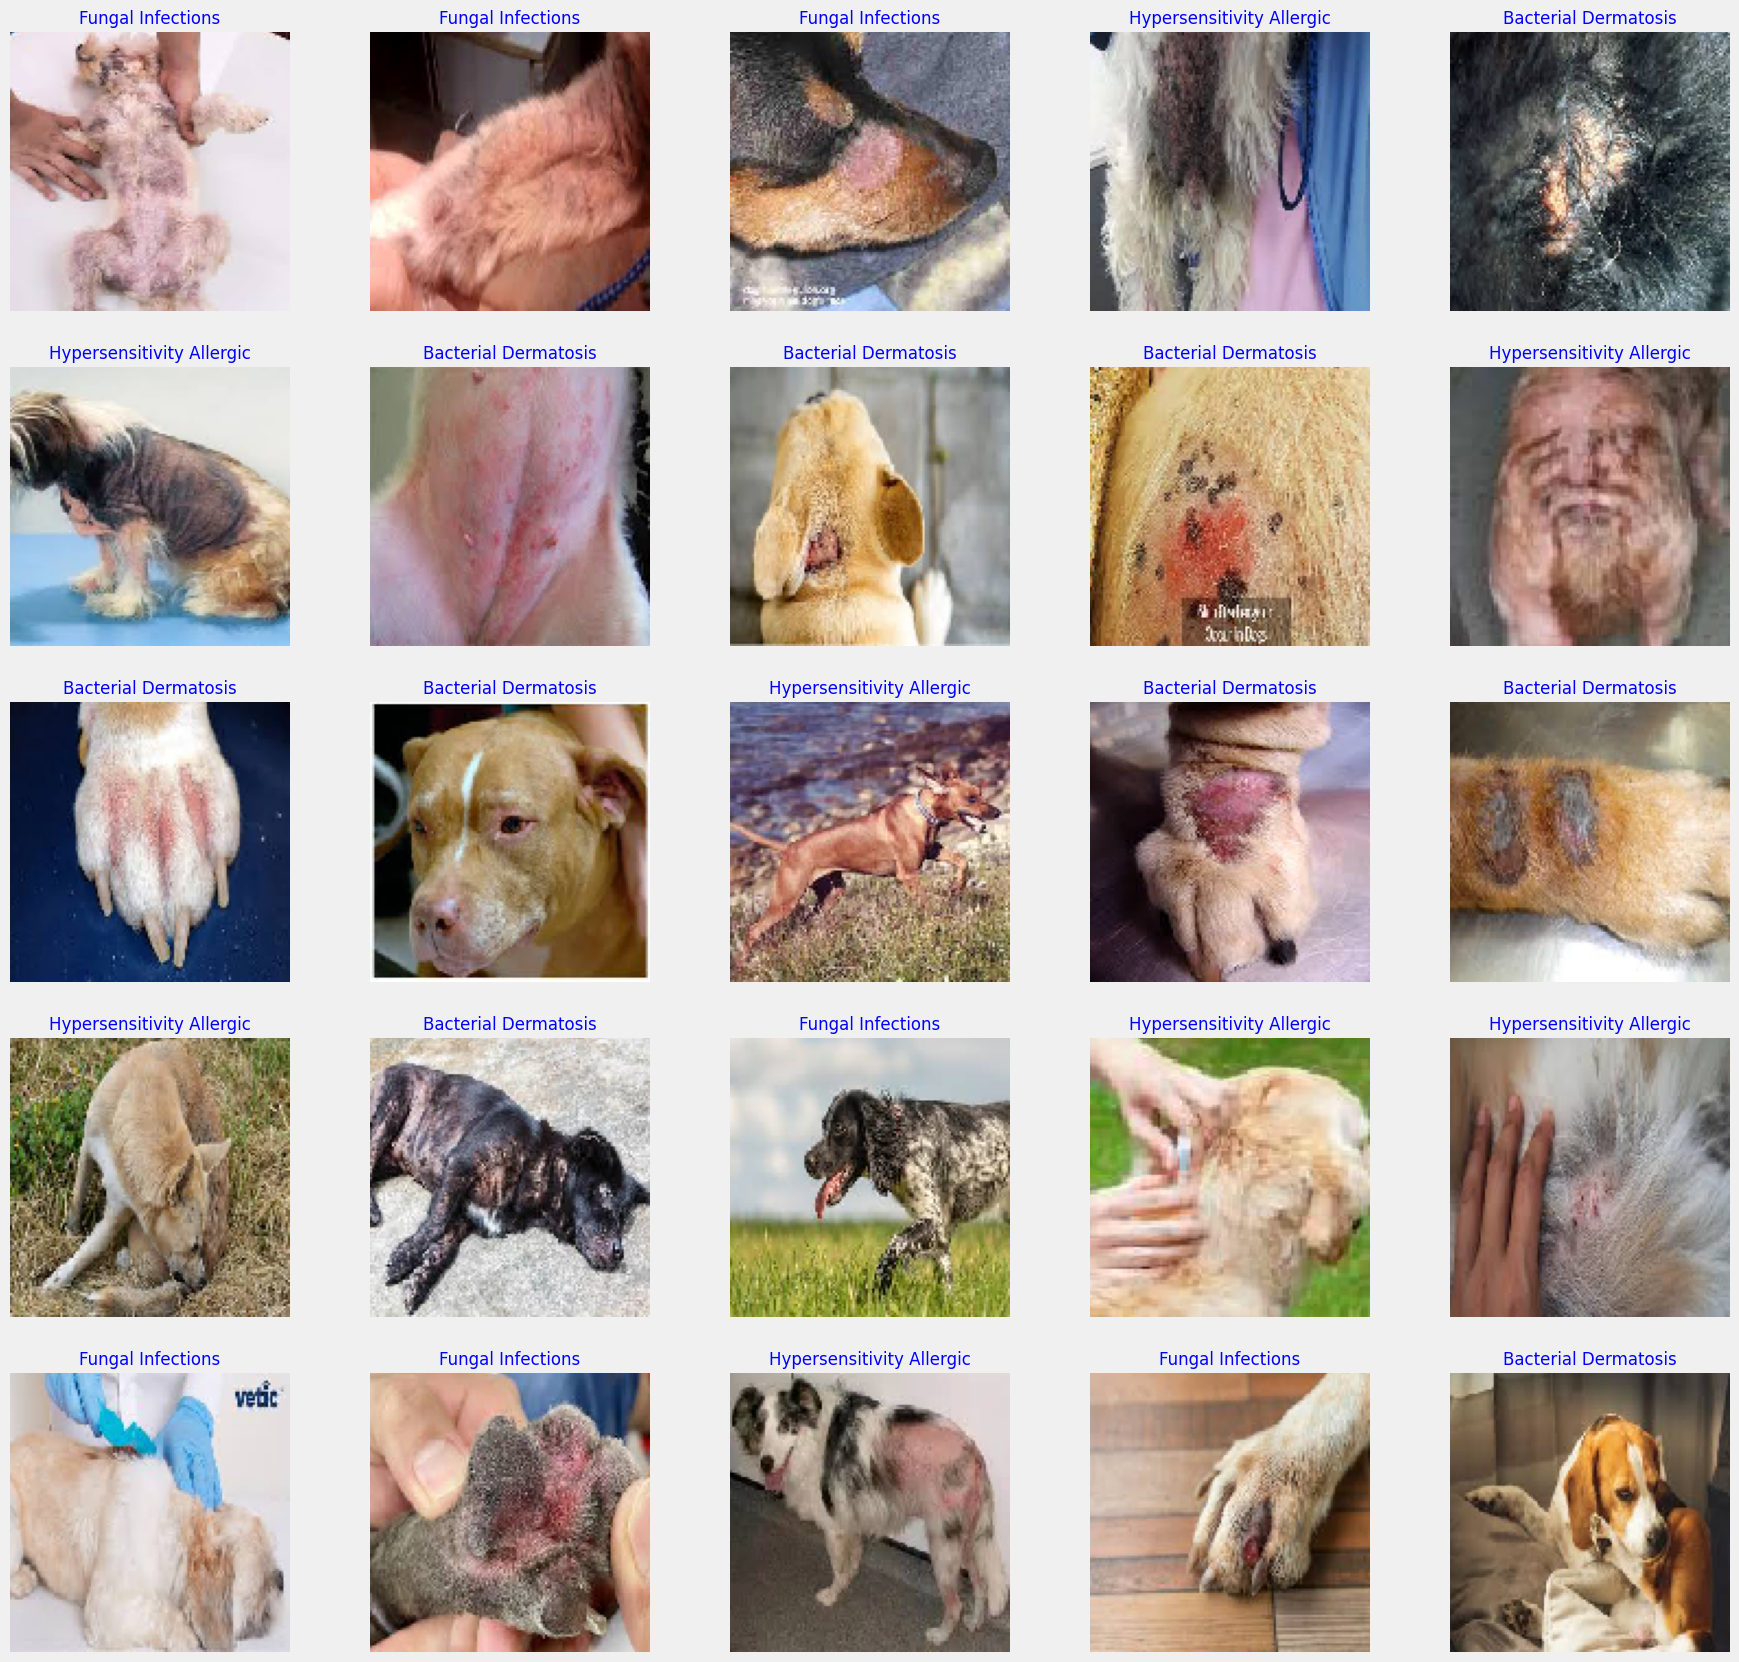

In [26]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(120,120,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3,activation='softmax')


])

In [28]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [29]:
history = model.fit(train_gen,epochs =25, validation_data = valid_gen)

Epoch 1/25
9/9 [==============================] - 7s 502ms/step - loss: 2.3936 - accuracy: 0.3283 - val_loss: 51.0102 - val_accuracy: 0.4444
Epoch 2/25
9/9 [==============================] - 4s 402ms/step - loss: 2.4204 - accuracy: 0.4340 - val_loss: 84.3521 - val_accuracy: 0.4444
Epoch 3/25
9/9 [==============================] - 4s 403ms/step - loss: 2.3762 - accuracy: 0.4189 - val_loss: 60.1048 - val_accuracy: 0.2778
Epoch 4/25
9/9 [==============================] - 4s 392ms/step - loss: 1.7776 - accuracy: 0.4340 - val_loss: 16.4667 - val_accuracy: 0.2222
Epoch 5/25
9/9 [==============================] - 3s 377ms/step - loss: 1.2615 - accuracy: 0.5623 - val_loss: 9.5810 - val_accuracy: 0.2778
Epoch 6/25
9/9 [==============================] - 4s 399ms/step - loss: 1.3180 - accuracy: 0.5057 - val_loss: 1.9615 - val_accuracy: 0.1667
Epoch 7/25
9/9 [==============================] - 4s 414ms/step - loss: 1.0387 - accuracy: 0.6038 - val_loss: 5.4829 - val_accuracy: 0.4444
Epoch 8/25
9/9 [

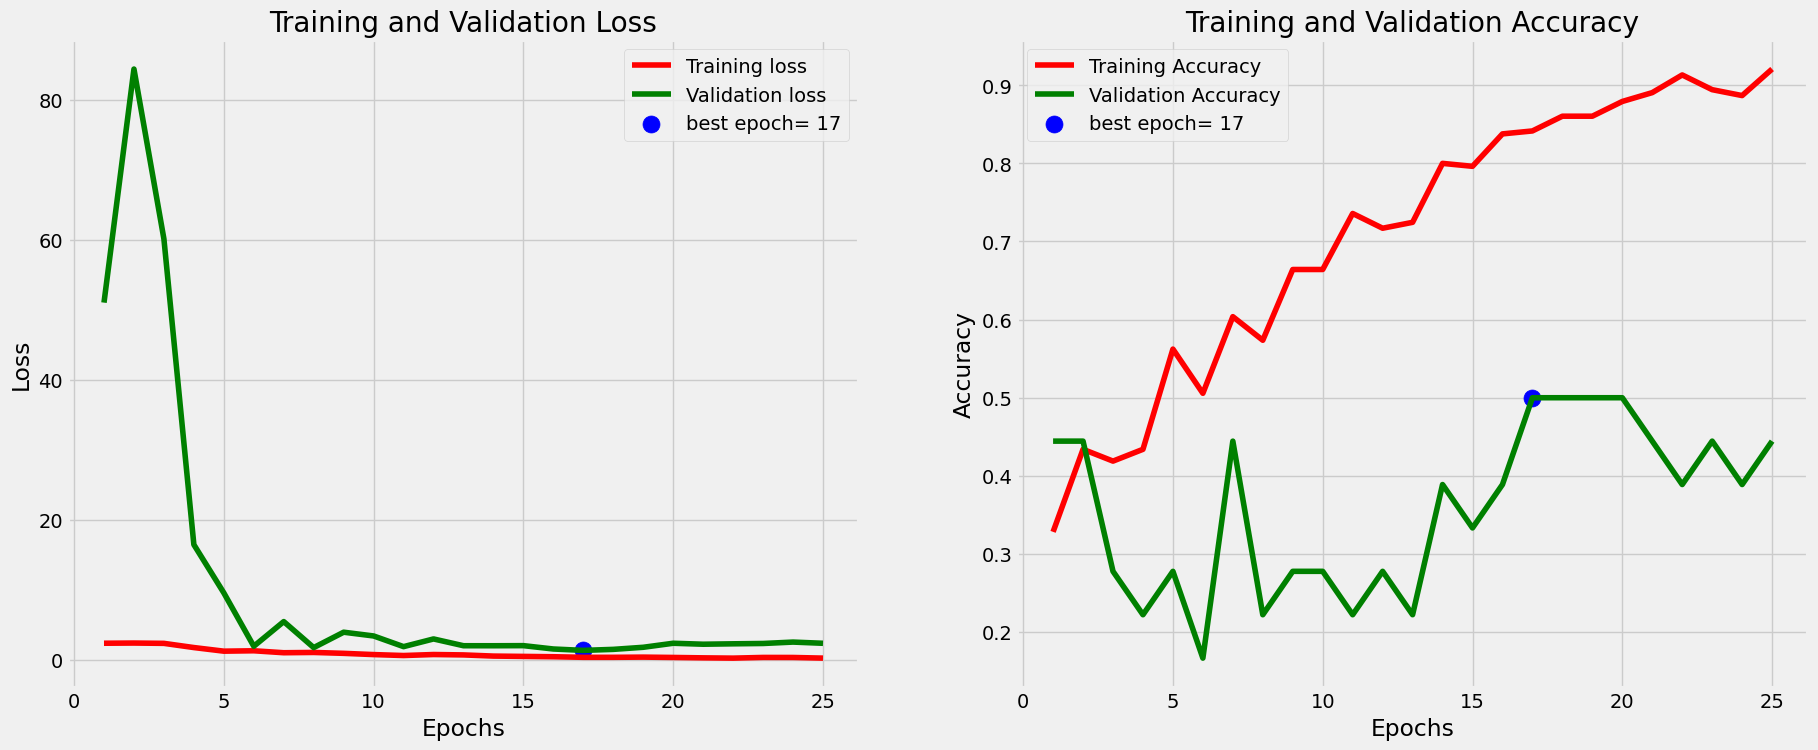

In [30]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout
plt.show()

In [31]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 0s 81ms/step - loss: 2.2590 - accuracy: 0.4167
Train Loss:  0.259157657623291
Train Accuracy:  0.90625
--------------------
Validation Loss:  2.3875792026519775
Validation Accuracy:  0.4444444477558136
--------------------
Test Loss:  2.25899600982666
Test Accuracy:  0.4166666567325592


In [32]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

y_true = test.gen.classes()
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))



C:\Users\AHAMED NUSRI\AppData\Local\Temp\ipykernel_16648\2138879732.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


NameError: name 'test' is not defined

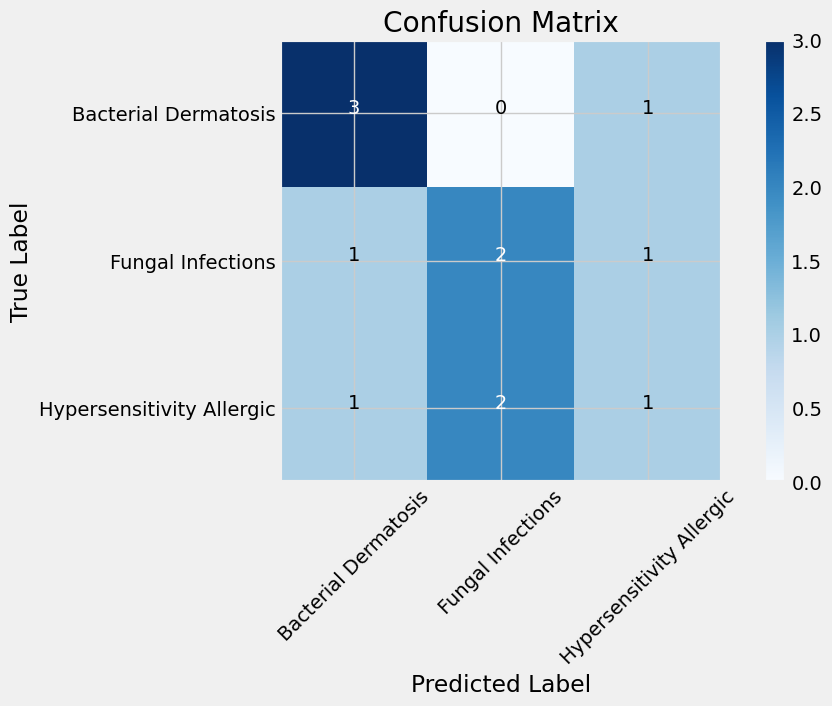

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 7))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
#Save the model
model.save('dog-disease-model-pooch-data.h5')

g:\Anaconda\envs\llm\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('dog-disease-model-pooch-data.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = 'Pooch-paw-Dataset\Bacterial Dermatosis\images (3).jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((120,120))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 284ms/step
Bacterial Dermatosis
